In [ ]:
import pandas as pd
from web3 import Web3

from mainnet_launch.constants import *

from mainnet_launch.database.schema.full import (
    AutopoolDeposit,
    AutopoolTransfer,
    AutopoolWithdrawal,
    Transactions,
    Blocks,
)
from mainnet_launch.database.schema.postgres_operations import get_full_table_as_df, _exec_sql_and_cache


deposit_df = get_full_table_as_df(AutopoolDeposit)
withdrawal_df = get_full_table_as_df(AutopoolWithdrawal)
transfer_df = get_full_table_as_df(AutopoolTransfer)
blocks_df = get_full_table_as_df(Blocks)
tx_df = get_full_table_as_df(Transactions)

In [122]:
tx_hash_to_block = tx_df.set_index("tx_hash")["block"].to_dict()
block_number_to_datetime = blocks_df.set_index("block")["datetime"].to_dict()
trasactions_has_to_eoa = tx_df.set_index("tx_hash")["from_address"].to_dict()

deposit_df["block"] = deposit_df["tx_hash"].map(tx_hash_to_block)
deposit_df["datetime"] = deposit_df["block"].map(block_number_to_datetime)
deposit_df["eoa_from_address"] = deposit_df["tx_hash"].map(trasactions_has_to_eoa)

withdrawal_df["block"] = withdrawal_df["tx_hash"].map(tx_hash_to_block)
withdrawal_df["datetime"] = withdrawal_df["block"].map(block_number_to_datetime)
withdrawal_df["eoa_from_address"] = withdrawal_df["tx_hash"].map(trasactions_has_to_eoa)

deposit_df.sort_values(by=["datetime"], inplace=True)
base_eth_deposits = deposit_df[deposit_df["autopool_vault_address"] == BASE_ETH.autopool_eth_addr].copy()
base_eth_withdrawals = withdrawal_df[withdrawal_df["autopool_vault_address"] == BASE_ETH.autopool_eth_addr].copy()
base_eth_transfers = transfer_df[transfer_df["autopool_vault_address"] == BASE_ETH.autopool_eth_addr].copy()
base_eth_transfers['block'] = base_eth_transfers['tx_hash'].map(tx_hash_to_block)

base_eth_mints = base_eth_transfers[base_eth_transfers["from_address"] == ZERO_ADDRESS][
    ["tx_hash", "from_address", "to_address", "value"]
].copy()

base_eth_df = pd.merge(base_eth_deposits, base_eth_mints, on="tx_hash")


real_mints = base_eth_df[base_eth_df['amount'] > 0].copy()

naive_mints = real_mints[real_mints["eoa_from_address"] == real_mints["to_address"]].copy()
strange_mints = real_mints[real_mints["eoa_from_address"] != real_mints["to_address"]].copy()
naive_mints['shares'].sum(), strange_mints['shares'].sum() # strange is 60%, so it is the standard way

(np.float64(1937.4056474011993), np.float64(3546.4301451340702))

# I want to understand this chart

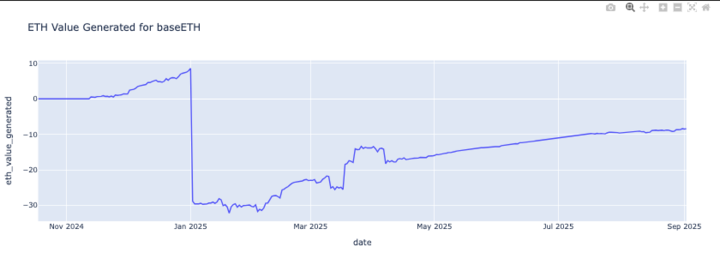



who made and lost money from this?

In [125]:
base_eth_transfers['block'].min(), base_eth_transfers['block'].max()

(np.int64(21241103), np.int64(35106250))

In [151]:
from mainnet_launch.constants import WETH, BASE_CHAIN
from mainnet_launch.data_fetching.get_events import fetch_events
from mainnet_launch.abis import ERC_20_ABI


# 'from':BASE_ETH.autopool_eth_addr
weth_contract = BASE_CHAIN.client.eth.contract(WETH(BASE_CHAIN), abi=ERC_20_ABI)
weth_to_autopool = fetch_events(weth_contract.events.Transfer,chain = BASE_CHAIN, start_block=21241103, end_block=35106250, argument_filters={'to':BASE_ETH.autopool_eth_addr})
weth_from_autopool = fetch_events(weth_contract.events.Transfer,chain = BASE_CHAIN, start_block=21241103, end_block=35106250, argument_filters={'from':BASE_ETH.autopool_eth_addr})
weth_from_autopool['weth'] = weth_from_autopool['value'].apply(lambda x: (int(x) / 10**18))
weth_to_autopool['weth'] = weth_to_autopool['value'].apply( lambda x: int(x) / 10**18)

Fetched 1,979 logs for <class 'web3._utils.datatypes.Transfer'> from 21,241,103 to 35,106,250 (13,865,148 blocks)
Fetched 724 logs for <class 'web3._utils.datatypes.Transfer'> from 21,241,103 to 35,106,250 (13,865,148 blocks)


In [159]:
BASE_ETH.autopool_eth_addr

'0xAADf01DD90aE0A6Bb9Eb908294658037096E0404'

In [158]:
weth_df = pd.concat([weth_to_autopool, weth_from_autopool]).sort_values(['block', 'log_index'])
weth_df['datetime'] = weth_df['block'].map(block_number_to_datetime)

autopool_all_time_value_sent_from_base_eth = weth_df[weth_df['from'] == BASE_ETH.autopool_eth_addr].groupby('to')['weth'].sum().rename('weth_taken_out').sort_values()
autopool_all_time_value_sent_to_base_eth = weth_df[weth_df['to'] == BASE_ETH.autopool_eth_addr].groupby('from')['weth'].sum().rename('weth_sent_in').sort_values()

weth_moved_df = pd.merge(autopool_all_time_value_sent_to_base_eth, autopool_all_time_value_sent_from_base_eth, left_index=True, right_index=True, how='outer').fillna(0)
weth_moved_df

,weth_sent_in,weth_taken_out
0x09618943342c016A85aC0F98Fd005479b3cec571,0.000000e+00,1.035487e-02
0x2Da80D9E73bd0e02C43877716d0837F881E93553,1.349033e-01,0.000000e+00
0x30BA9c99BF5f25C022E1ebF20508C87342FE5911,0.000000e+00,1.000000e-17
0x391976D9Cd4e7Af3E4FD6De7fCC8c8CFfAD7F593,1.241712e-01,1.242068e-01
0x3A43AEC53490CB9Fa922847385D82fe25d0E9De7,7.459594e+01,7.485956e+01
0x3A619a042ad04D9AE03c6bBB7262ADf8769d9137,0.000000e+00,2.610748e+00
0x3F7C10cBbb1EA1046a80B738b9Eaf3217410c7F6,0.000000e+00,3.523320e+01
0x456EbB97107D0Ee728E4B87289624d34116c9284,0.000000e+00,1.000000e-17
0x4D2b87339b1f9e480aA84c770fa3604D7D40f8DF,3.134209e+02,3.935144e+02
0x4Db87fc0f44303a5b279c87DbA1879C3249a4ce4,6.695889e-01,0.000000e+00


In [156]:
autopool_all_time_value_sent_to_base_eth

from
0x2Da80D9E73bd0e02C43877716d0837F881E93553    1.349033e-01
0x391976D9Cd4e7Af3E4FD6De7fCC8c8CFfAD7F593    1.241712e-01
0x3A43AEC53490CB9Fa922847385D82fe25d0E9De7    7.459594e+01
0x4D2b87339b1f9e480aA84c770fa3604D7D40f8DF    3.134209e+02
0x4Db87fc0f44303a5b279c87DbA1879C3249a4ce4    6.695889e-01
0x61e789DD14B73d0730db7EB2d67300577ae0dBA4    3.208109e+00
0x71761bf6512BC76FB7169D3fa25E83EF5c85F816    3.088439e+03
0x78A7c45E3cC7B9567b4803AEAF9b33bC8c898451    1.000000e-13
0x945a4f719018edBa445ca67bDa43663C815835Ad    1.568029e+03
0x97c98De076cc8d3880c932DdaD4E4748eF8212c9    4.073139e+01
0xA0A8D16522f96A32fa7eab5D13696B770c3Fed0d    1.840579e+00
0xB8840f50487Ef87f998237C51a4d6041AcAe5F6D    1.033438e+01
0xBd137c56f3116E5c36753037a784FF844F84F59c    5.209934e+02
0xC3337192143EB496eed206C8c4249F7Cdee19078    4.067342e-01
0xa18B89225491230fDb1883cFbda65E7931606931    2.077223e+03
0xa6EFB95B7393cB419B48A933273F49b6bb48dd5D    1.465794e+03
0xa97f1ABDF3bbFCEA0Ffd74f310d3C512761A00f6    1.332

In [138]:
weth_to_autopool

,event,block,transactionIndex,log_index,hash,from,to,value,weth
0,Transfer,21241103,99,334,0xadf67a3dd1b7bb8c59f818d7f04e65f7f90963c90bce...,0x78A7c45E3cC7B9567b4803AEAF9b33bC8c898451,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,100000,<function <lambda>.<locals>.<lambda> at 0x1177...
1,Transfer,21417939,19,67,0xb00590b29e59ccd29ec875904dc1dcc00e0a792ea299...,0x71761bf6512BC76FB7169D3fa25E83EF5c85F816,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,1000000000000000,<function <lambda>.<locals>.<lambda> at 0x1177...
2,Transfer,21418088,39,83,0x4138e2ee96d62376bdcb75f6b59b168d666165b0082e...,0x71761bf6512BC76FB7169D3fa25E83EF5c85F816,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,996020459611820,<function <lambda>.<locals>.<lambda> at 0x1177...
3,Transfer,21979155,33,111,0xc46da0cf7e255e7d04ae34bf6241e50546bf1579cb78...,0x71761bf6512BC76FB7169D3fa25E83EF5c85F816,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,10000000000000000,<function <lambda>.<locals>.<lambda> at 0x1177...
4,Transfer,22024837,101,256,0x77262c96a4c43dadb94ad3b59b6809eb67f8c9d5246a...,0x71761bf6512BC76FB7169D3fa25E83EF5c85F816,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,1000000000000000,<function <lambda>.<locals>.<lambda> at 0x1177...
...,...,...,...,...,...,...,...,...,...
1974,Transfer,35015980,13,66,0x4f6630d42a353939a2cfd631a286f1288e208f55abe1...,0xB8840f50487Ef87f998237C51a4d6041AcAe5F6D,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,1280678380401255,<function <lambda>.<locals>.<lambda> at 0x1449...
1975,Transfer,35059180,62,396,0x15d094cf4e750a6bc3488375abc9ada97684705a122f...,0xA0A8D16522f96A32fa7eab5D13696B770c3Fed0d,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,16331151482842856,<function <lambda>.<locals>.<lambda> at 0x1449...
1976,Transfer,35059180,62,402,0x15d094cf4e750a6bc3488375abc9ada97684705a122f...,0xB8840f50487Ef87f998237C51a4d6041AcAe5F6D,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,1655863684045497,<function <lambda>.<locals>.<lambda> at 0x1449...
1977,Transfer,35102380,14,45,0x618c49c29ac3ba3e07c77ecc787762546c1898aa5f1c...,0xA0A8D16522f96A32fa7eab5D13696B770c3Fed0d,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,16387258648984158,<function <lambda>.<locals>.<lambda> at 0x1449...
